In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf

In [3]:
df = pd.read_csv("Output/simulation_results_parallel_in_silico.csv")

V_c = df["V_c"].iloc[0].split(",")   
V_c = [float(x) for x in V_c]
V_dis = df["V_dis"].iloc[0].split(",")   
V_dis = [float(x) for x in V_dis]


N_D = 20  # Number of N_j columns: N_0 to N_19

# Collect all N_j lists for the first row
N_all = []
for j in range(N_D):
    col = f"N_{j}"
    if col in df.columns:
        # Extract, split and convert to float
        values = [float(x) for x in df[col].iloc[0].split(",")]
        N_all.append(values)



N_x = 200
L = 1.3
D = 0.2
x = np.linspace(0, L, N_x)
dl = x[1] - x[0]

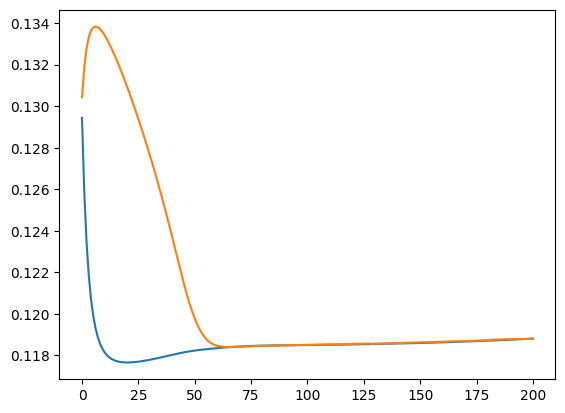

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97     True
98    False
99    False
Name: dpz_flooded, Length: 100, dtype: bool


In [4]:
V_c = np.array(V_c)
V_dis = np.array(V_dis)
h_c = hf.getHeightArray(V_c/dl, D/2)
h_dis = hf.getHeightArray((V_c+V_dis)/dl, D/2)
plt.plot(h_c)
plt.plot(h_dis)
plt.show()
h_dpz_flooded = df['dpz_flooded']
print(h_dpz_flooded)

6.460322571700715


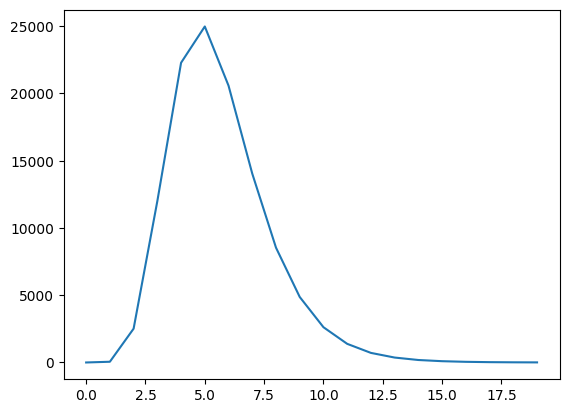

In [20]:
N_all = np.array(N_all)
plt.plot(N_all[:,0])
print(N_all[-1,0])